In [1]:
import cv2
import numpy as np
import os

avgimage = 0

os.chdir('/Users/braydennoh/Downloads/flocphase3/slit')

def find_particles_centers_and_circularity(image, frame_num, avgimage):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_float = gray.astype(np.float32) / 255.0  
    filtered_gray_float = gray_float - avgimage 
    filtered_gray = (filtered_gray_float * 255).astype(np.uint8)  

    equalized_gray = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized_gray, (5, 5), 10)
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    dilation_kernel = np.ones((3, 3), np.uint16)
    dilated = cv2.dilate(cleaned, dilation_kernel, iterations=20)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centers_circularity_sphericity_ids = []

    for cnt in contours:
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        masked_img = cv2.bitwise_and(blurred, blurred, mask=mask)
        laplacian = cv2.Laplacian(masked_img, cv2.CV_64F)
        laplacian_variance = laplacian.var()
        
        if laplacian_variance < 3 or laplacian_variance > 10:
            continue
            
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter > 0 else 0
        sphericity = area / (perimeter ** 2 / (4 * np.pi)) if perimeter > 0 else 0  
    
        major_axis_length = 0
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            major_axis_length = max(ellipse[1])  
        else:
            rect = cv2.minAreaRect(cnt)
            major_axis_length = max(rect[1])  

        avg_intensity = cv2.mean(gray, mask=mask)[0]

        centers_circularity_sphericity_ids.append(((cx, cy), area, circularity, sphericity, major_axis_length, laplacian_variance, avg_intensity))

    return contours, centers_circularity_sphericity_ids



def process_frame_pair(frame_num1, frame_num2, avgimage):
    pixel_to_micron = 0.81
    time_between_frames = 1/30
    dilation_increase_per_iteration = 2  
    dilation_iterations = 20
    
    image1 = cv2.imread(f'frame_{frame_num1:04}.png')
    image2 = cv2.imread(f'frame_{frame_num2:04}.png')

    _, centers_circularity_sphericity_ids1 = find_particles_centers_and_circularity(image1, frame_num1, avgimage)
    _, centers_circularity_sphericity_ids2 = find_particles_centers_and_circularity(image2, frame_num2, avgimage)
    
    matched_particles = set()
    local_diameters = []
    local_velocities = []
    laplacian_variances = []
    local_circularities = []
    local_sphericities = []
    average_intensities = []

    for data1 in centers_circularity_sphericity_ids1:
        center1, area1, circularity1, sphericity1, major_axis_length1, laplacian_variance1, avg_intensity1 = data1
        best_match = match_by_circularity((center1, area1, circularity1, sphericity1), centers_circularity_sphericity_ids2, 500)
        
        if best_match:
            center2, area2, circularity2, sphericity2, major_axis_length2, laplacian_variance2, avg_intensity2 = best_match
            if (center2, area2, circularity2, sphericity2) not in matched_particles:
                matched_particles.add((center2, area2, circularity2, sphericity2))

            total_dilation_increase = dilation_increase_per_iteration * dilation_iterations
            adjusted_major_axis_length1 = max(major_axis_length1 - total_dilation_increase, 0)
            
            diameterinpixel = 2 * np.sqrt(area1 / np.pi)
            adjusteddiameterinpixel = diameterinpixel - total_dilation_increase
            diameter_microns = adjusteddiameterinpixel * pixel_to_micron
            
            local_diameters.append(diameter_microns)
            euclidean_distance_pixels = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
            euclidean_distance_microns = euclidean_distance_pixels * pixel_to_micron
            velocity = euclidean_distance_microns / time_between_frames
            local_velocities.append(velocity)
            laplacian_variances.append(laplacian_variance1)
            local_circularities.append(circularity1)
            local_sphericities.append(sphericity1)
            average_intensities.append(avg_intensity1)
    
    return local_diameters, local_velocities, laplacian_variances, local_circularities, local_sphericities, average_intensities

def match_by_circularity(center_circularity1, centers_circularity2, search_radius):
    best_match = None
    min_combined_diff = float('inf')

    center1, area1, circularity1, sphericity1 = center_circularity1[:4]

    for center2, area2, circularity2, sphericity2, major_axis_length2, laplacian_variance2, avg_intensity2 in centers_circularity2:
        distance = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
        
        if distance <= search_radius:
            area_diff_ratio = abs(area1 - area2) / area1
            if area_diff_ratio <= 0.10:
                circularity_diff = abs(circularity1 - circularity2)
                sphericity_diff = abs(sphericity1 - sphericity2)
                combined_diff = circularity_diff + sphericity_diff
                
                if combined_diff < min_combined_diff:
                    min_combined_diff = combined_diff
                    best_match = (center2, area2, circularity2, sphericity2, major_axis_length2, laplacian_variance2, avg_intensity2)

    return best_match



all_diameters = []
all_velocities = []
all_laplacian_variances = []
all_circularities = []
all_sphericities = []
all_average_intensities = []

for frame_num in range(500, 1500):
    diameters, velocities, laplacian_variances, circularities, sphericities, average_intensities = process_frame_pair(frame_num, frame_num + 1, avgimage)
    all_diameters.extend(diameters)
    all_velocities.extend(velocities)
    all_laplacian_variances.extend(laplacian_variances)
    all_circularities.extend(circularities)
    all_sphericities.extend(sphericities)
    all_average_intensities.extend(average_intensities)

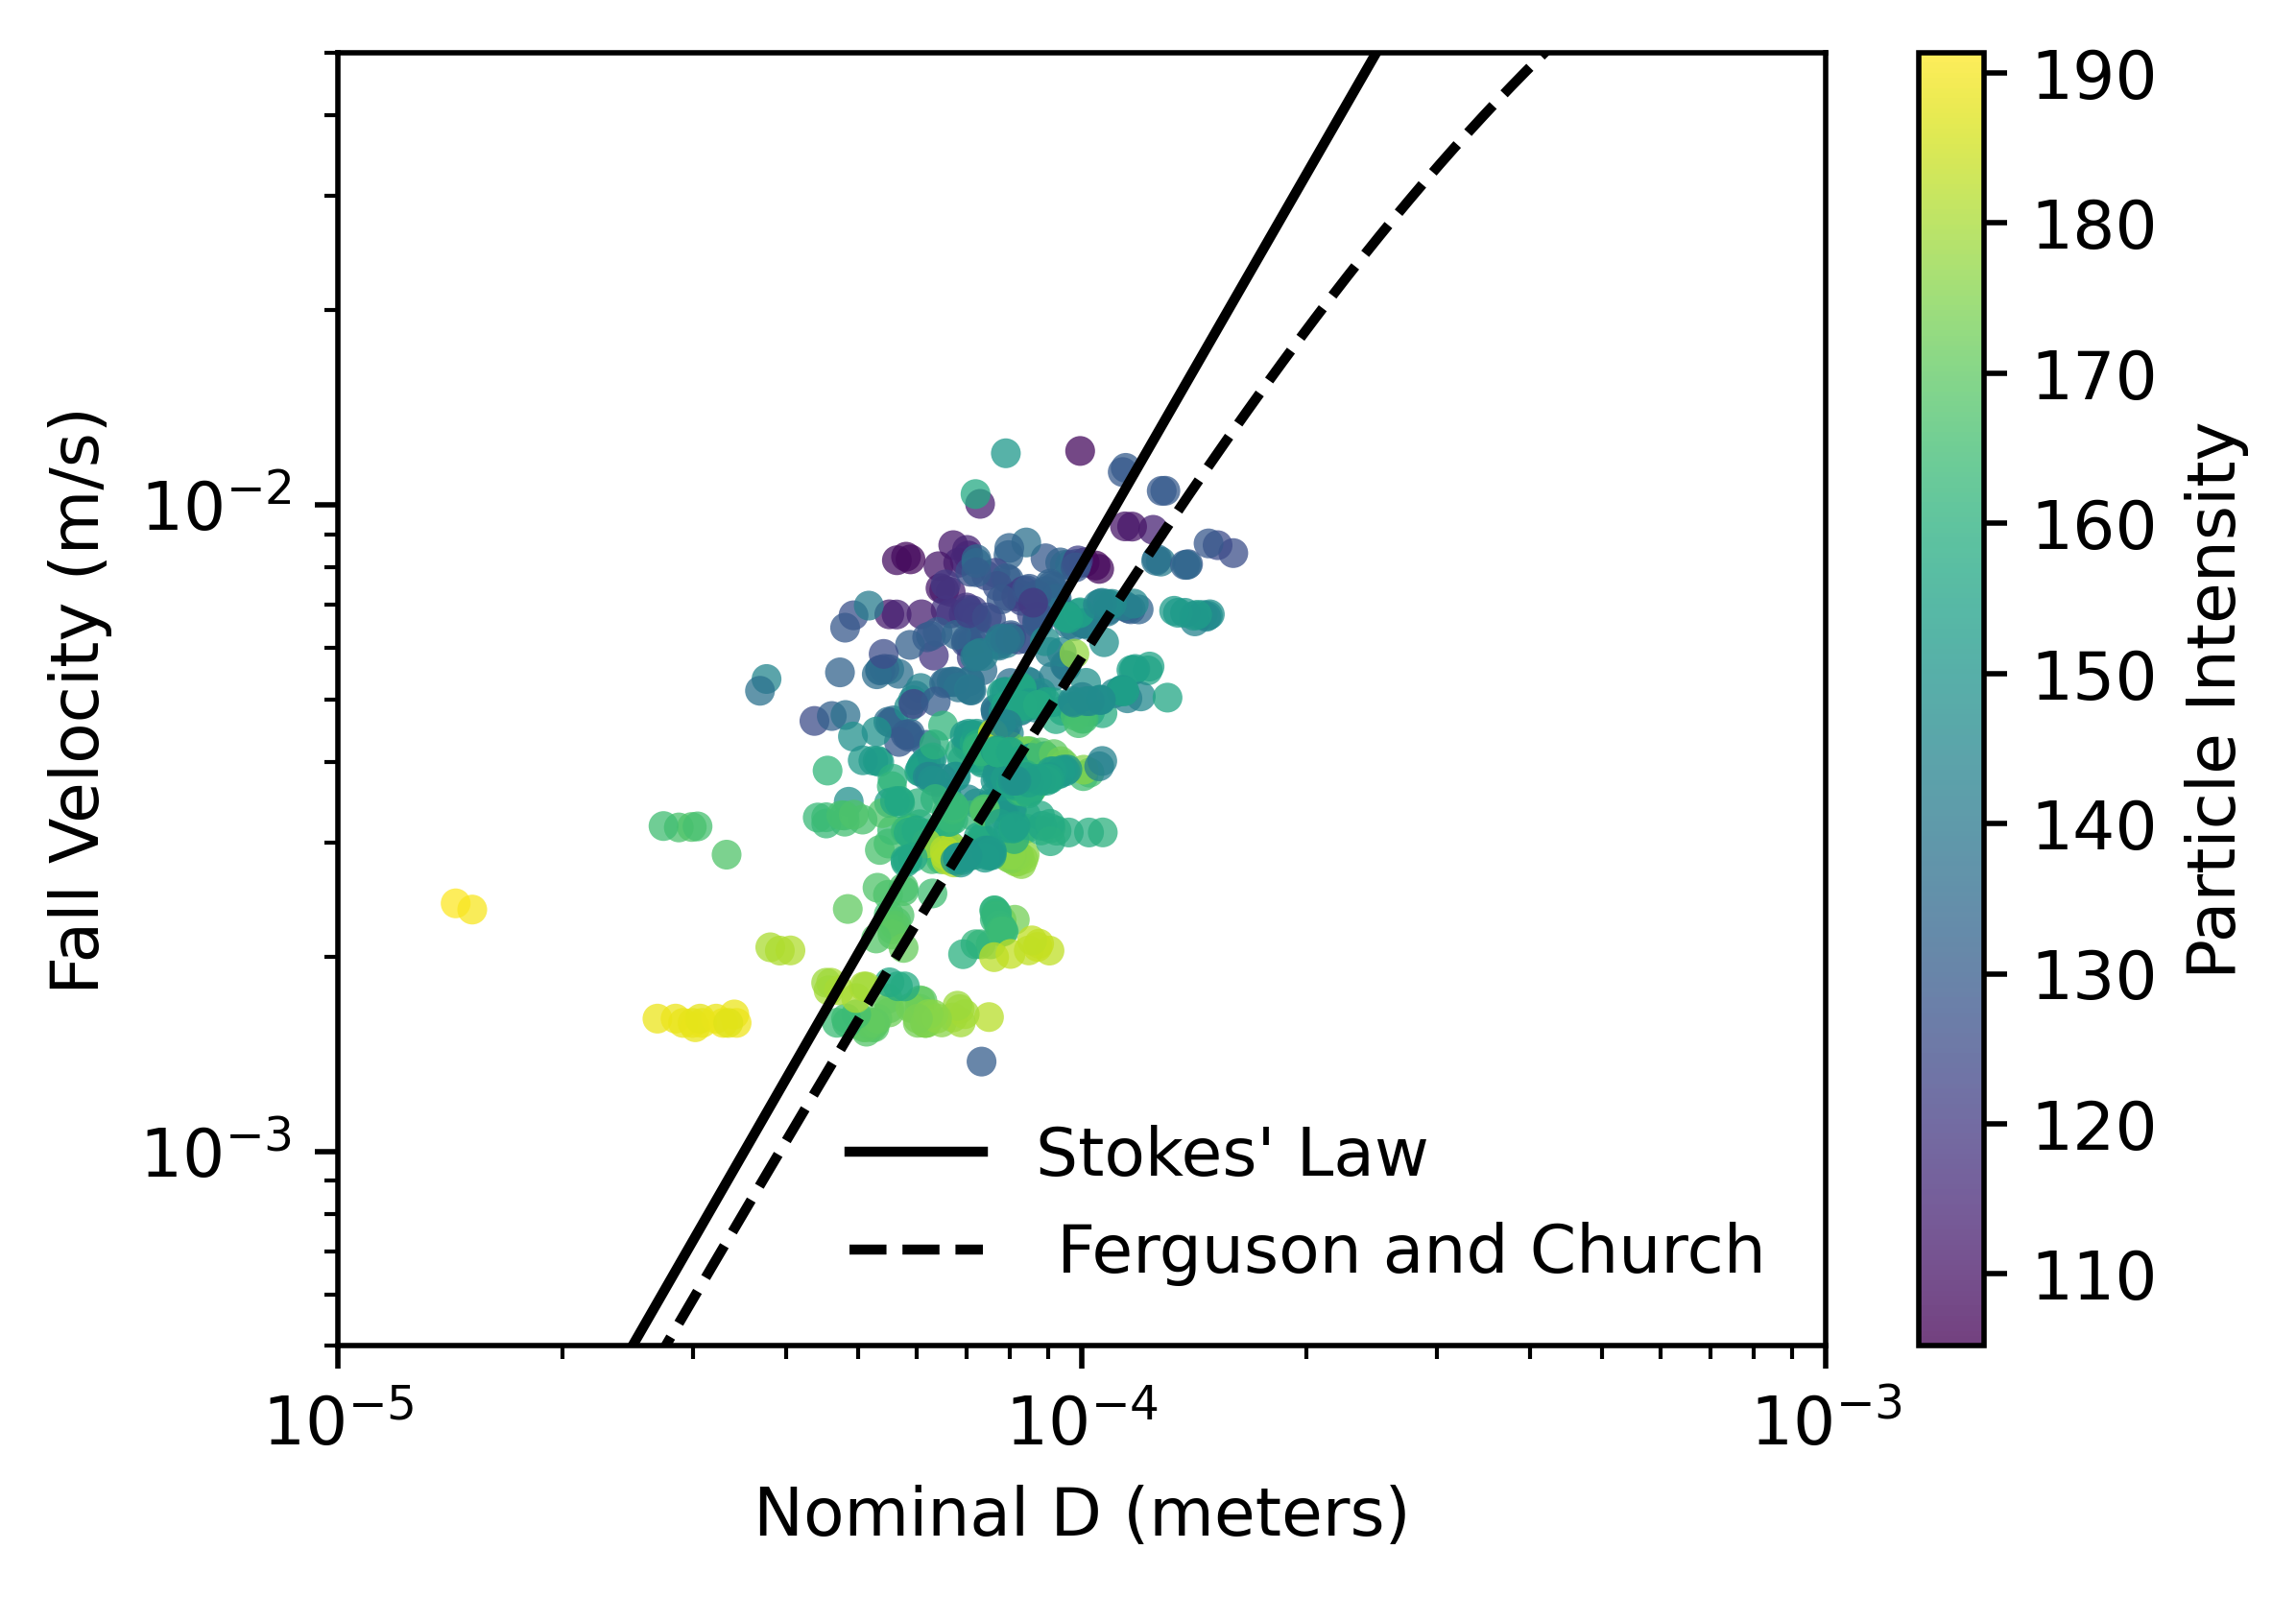

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 500

diametersmeters = [d / 1000000 for d in all_diameters]
velocitiesmeters = [v / 1000000 for v in all_velocities]

R = 1.65  # submerged specific gravity for quartz in water
g = 9.81  # acceleration due to gravity in m/s^2
ν = 1.0e-6  # kinematic viscosity of the fluid in kg m^-1 s^-1 for water at 20°C
C1 = 20  # theoretical constant
C2 = 1.1   # constant for smooth spheres

def stokes_law(D):
    return (R * g * D**2) / (C1 * ν)

def modified_stokes_law_rough(D):
    return (R * g * D**2) / (24 * ν + (0.75 * 1.2 * R * g * D**3)**0.5)

diameter_range_corrected = np.logspace(-5, -3, 10000)
fall_velocity = stokes_law(diameter_range_corrected)
fall_velocity_rough = modified_stokes_law_rough(diameter_range_corrected)
plt.figure(figsize=(5, 3.5))
plt.plot(diameter_range_corrected, fall_velocity, label="Stokes' Law",color='black')
plt.plot(diameter_range_corrected, fall_velocity_rough,  ls="--",label=" Ferguson and Church",color='black')
plt.scatter(diametersmeters, velocitiesmeters, c=all_average_intensities, cmap='viridis', s=20, alpha=0.75, edgecolor='none')
plt.colorbar(label='Particle Intensity')
plt.xlabel('Nominal D (meters)')
plt.ylabel('Fall Velocity (m/s)')
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.0005,0.05])
plt.xlim([0.00001,0.001])
plt.legend(frameon=False)
plt.show()

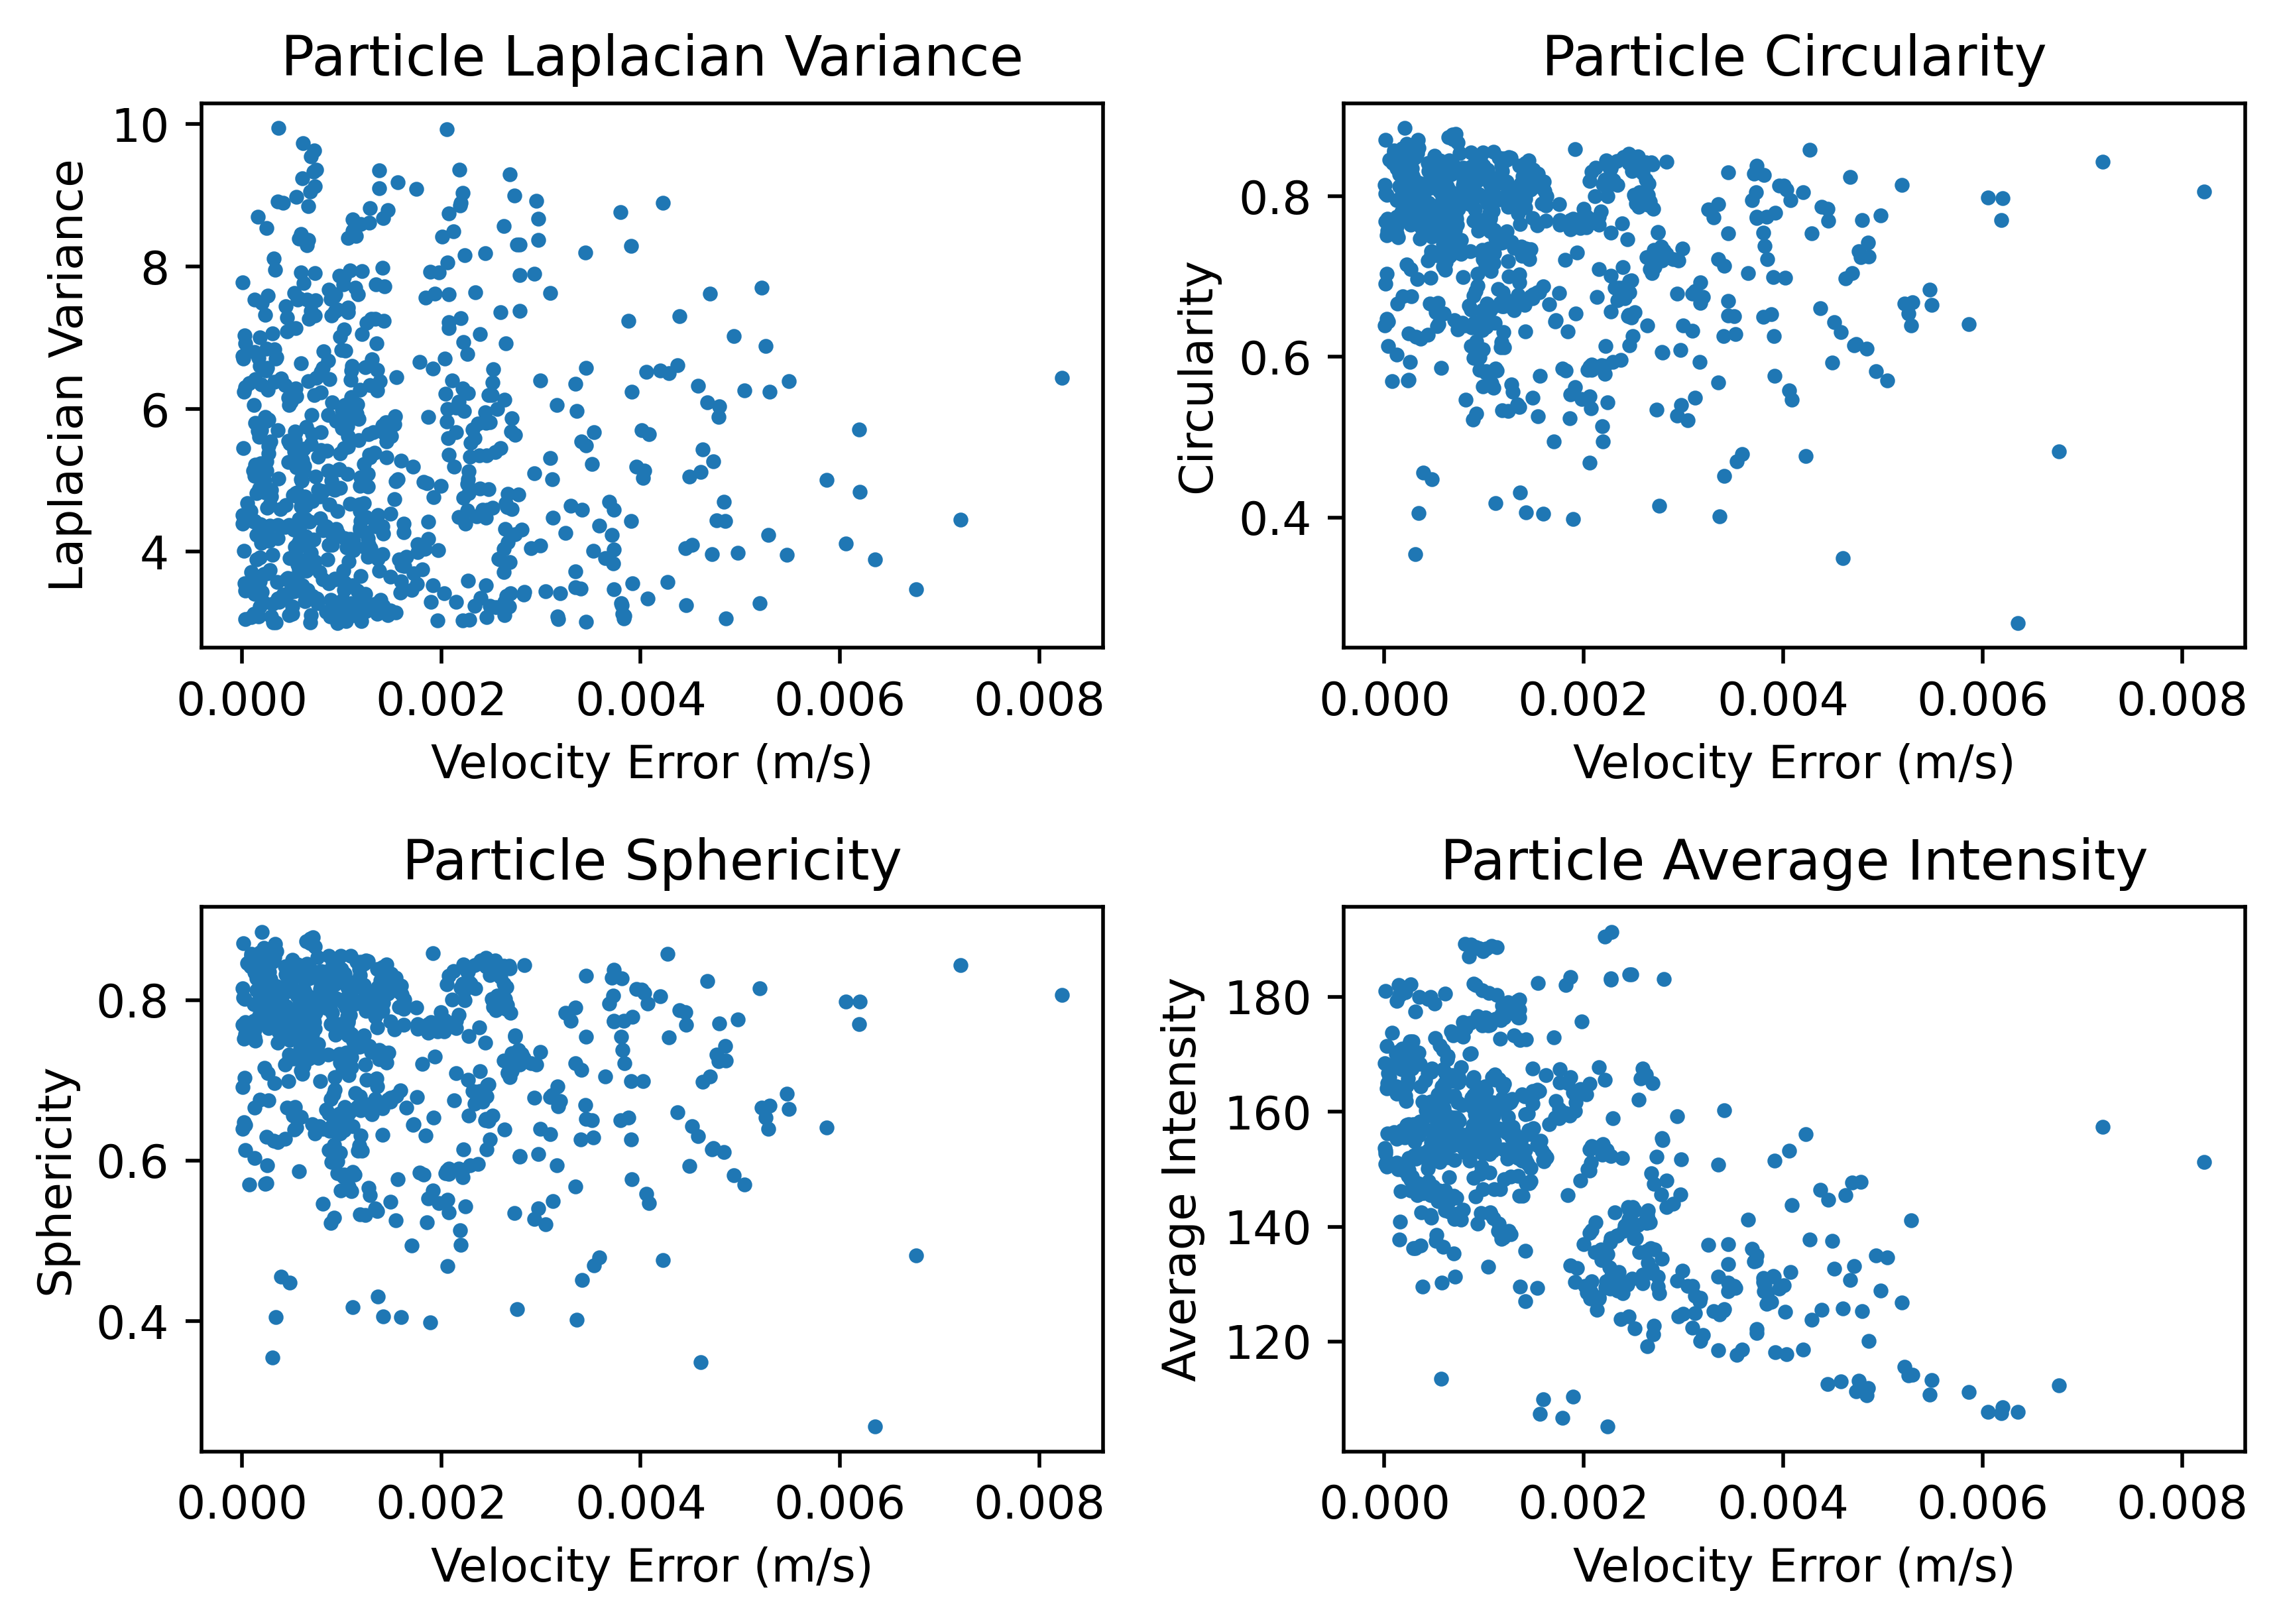

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

R = 1.65  # submerged specific gravity for quartz in water
g = 9.81  # acceleration due to gravity in m/s^2
ν = 1.0e-6  # kinematic viscosity of the fluid in kg m^-1 s^-1 for water at 20°C
C1 = 20  # theoretical constant
C2 = 1.1  # constant for smooth spheres

diametersmeters = [d / 1000000 for d in all_diameters]
velocitiesmeters = [v / 1000000 for v in all_velocities]

def modified_stokes_law_rough(D):
    return (R * g * D**2) / (24 * ν + (0.75 * 1.2 * R * g * D**3)**0.5)

fall_velocity_rough = [modified_stokes_law_rough(d) for d in diametersmeters]

velocity_errors = np.abs([obs - theo for obs, theo in zip(velocitiesmeters, fall_velocity_rough)])

diameter_range_corrected = np.logspace(np.log10(min(diametersmeters)), np.log10(max(diametersmeters)), num=500)
theoretical_velocities = modified_stokes_law_rough(diameter_range_corrected)

fig, axs = plt.subplots(2, 2, figsize=(7, 5))

axs[0, 0].scatter(velocity_errors, all_laplacian_variances,s=5)
axs[0, 0].set_xlabel("Velocity Error (m/s)")
axs[0, 0].set_ylabel("Laplacian Variance")
axs[0, 0].set_title("Particle Laplacian Variance")

axs[0, 1].scatter(velocity_errors, all_circularities,s=5)
axs[0, 1].set_xlabel("Velocity Error (m/s)")
axs[0, 1].set_ylabel("Circularity")
axs[0, 1].set_title("Particle Circularity")

axs[1, 0].scatter(velocity_errors, all_sphericities,s=5)
axs[1, 0].set_xlabel("Velocity Error (m/s)")
axs[1, 0].set_ylabel("Sphericity")
axs[1, 0].set_title("Particle Sphericity")

axs[1, 1].scatter(velocity_errors, all_average_intensities,s=5)
axs[1, 1].set_xlabel("Velocity Error (m/s)")
axs[1, 1].set_ylabel("Average Intensity")
axs[1, 1].set_title("Particle Average Intensity")

plt.tight_layout()
plt.show()

Mean Squared Error: 1.52357134945543e-06


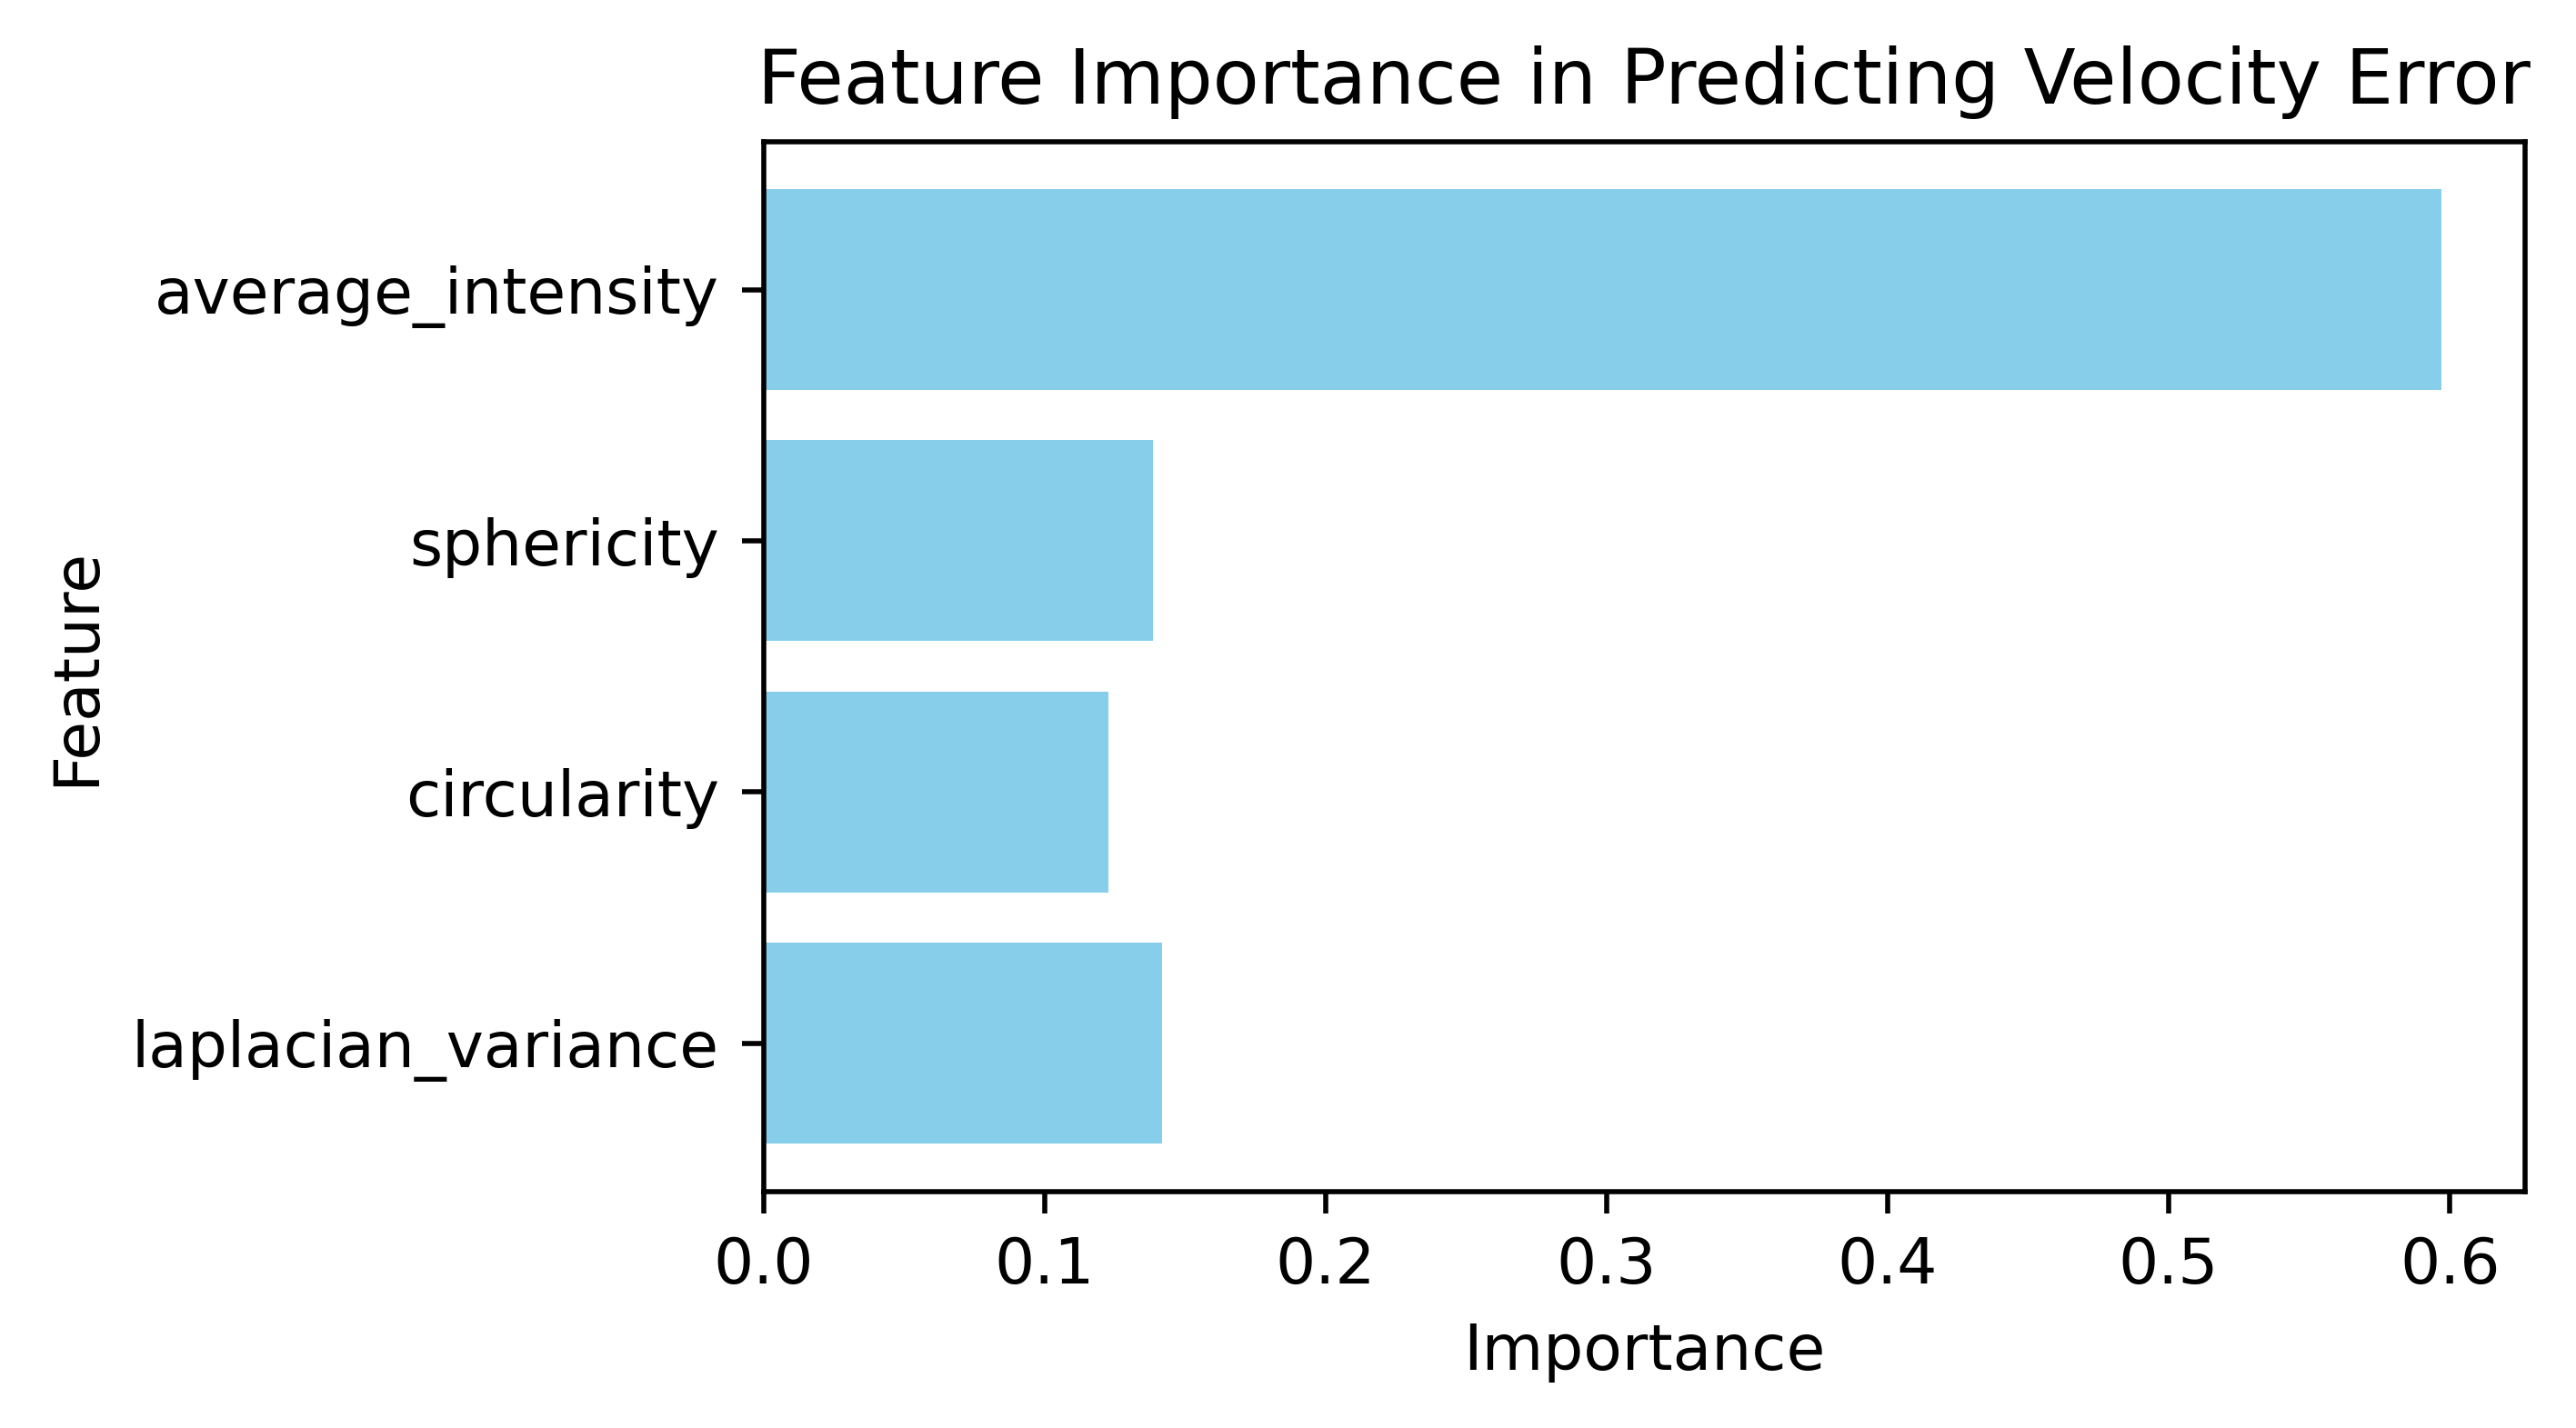

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

data = {
    'diameter': all_diameters,
    'velocity': all_velocities,
    'laplacian_variance': all_laplacian_variances,
    'circularity': all_circularities,
    'sphericity': all_sphericities,
    'average_intensity': all_average_intensities
}

df = pd.DataFrame(data)

df['diameter_m'] = df['diameter'] / 1000000
df['velocity_m'] = df['velocity'] / 1000000

df['theoretical_velocity'] = df['diameter_m'].apply(modified_stokes_law_rough)

df['velocity_error'] = df['velocity_m'] - df['theoretical_velocity']

features = df[['laplacian_variance', 'circularity', 'sphericity', 'average_intensity']]
target = df['velocity_error']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

feature_importances = rf.feature_importances_

feature_names = features.columns
plt.figure(figsize=(5, 3))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Velocity Error')
plt.show()